# 1. Load hcp data

In [42]:
import numpy as np
import glob
import re
import pandas as pd 

# Specify the folder path containing the text files
folder_path = "/Users/mioulin/Desktop/hcp_fix_ts/"

# Get a list of file paths in the folder
file_paths = glob.glob(folder_path + "*")

# Initialize the dictionary
hcp_ts = {}

# Iterate over each file and load it into an array
for file_path in file_paths:
    # Extract the numeric part of the file name
    file_name = re.findall(r'\d+', file_path)[0]
    
    # Load the text file into an array
    data_array = np.genfromtxt(file_path, delimiter=',')
    
    # Store the array in the dictionary
    hcp_ts[file_name] = data_array



# TEMPORAL SMMOTHING FMRI APPROACHES 

# 1) Moving Average (or Rolling Mean) Filter: 

This is a simple and commonly used method for temporal smoothing. The principle behind the moving average is to create a new series where the value at each point is the average of the last 'n' values in the original series, where 'n' is a parameter you define. This will smooth out the short-term fluctuations and highlight longer-term trends or cycles


# 2) Decimation: 

Decimation involves first applying a low-pass filter to the signal and then downsampling it. The low-pass filter is important as it helps to avoid aliasing. Aliasing is a problem where high-frequency information in the signal becomes indistinguishable after downsampling.

# 3) Resampling: 

Resampling, or downsampling, is the process of reducing the sampling rate, or the number of samples per unit of time in a signal

In [54]:
# Moving average 

import pandas as pd
from scipy.signal import resample

# input_dict is your original dictionary
hcp_moving_avg_resample = {}
for key, matrix in hcp_ts.items():
    smoothed_matrix = pd.DataFrame(matrix.T).rolling(window=1).mean().dropna()  # Apply smoothing for each time series
    resampled_matrix = np.array([resample(row, 200) for row in smoothed_matrix.values])  # Apply resampling for each time series
    hcp_moving_avg_resample[key] = resampled_matrix.T  # Transpose back to original dimension


In [35]:
# Decimation 

from scipy.signal import decimate

hcp_decim = {}
for key, matrix in hcp_ts.items():
    decimated_matrix = np.array([decimate(row, 6) for row in matrix.T])  # Apply decimation for each time series
    hcp_decim[key] = decimated_matrix.T  # Transpose back to original dimension


In [57]:
# Resampling

from scipy.signal import resample

hcp_resample = {}
for key, matrix in hcp_ts.items():
    resampled_matrix = np.array([resample(row, 200) for row in matrix.T])  # Apply resampling for each time series
    hcp_resample[key] = resampled_matrix.T  # Transpose back to original dimension


In [60]:
hcp_resample['654754'].shape

(200, 100)

# 2. Load gradient data

In [7]:
# Load hcp functional connectivitty from brainspace toolbox: 
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69

# First load mean connectivity matrix and Schaefer parcellation
conn_matrix = load_group_fc('schaefer', scale=100)
labeling = load_parcellation('schaefer', scale=100, join=True)
from brainspace.gradient import GradientMaps

# Ask for one fc hcp grad
gm = GradientMaps(n_components=3, random_state=0)
gm.fit(conn_matrix)
grad_hcp = gm.gradients_

/Users/mioulin/opt/anaconda3/lib/python3.9/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


# 3. Project HCP into Gradient Space 

In [55]:
def vcorrelate(X,y):
    
    #Create input for vector
    
    N = X.shape[0]
    k = y.shape[0]
    r = np.zeros((N,k))
    
    # output
    for j in range(k):
        for i in range(N):
            r[i,j] = np.corrcoef(X[i,:], y[j])[0,1]
    return r

In [61]:
import numpy as np

corr_results_hcp = {}
b = grad_hcp.T

for subject, series in  hcp_resample.items():
        X = np.array(series)  # Convert the series data to a NumPy array
        corr_results_hcp[subject] = np.corrcoef(X, b)

In [102]:
import pickle

# Save the dictionary as a binary file using pickle
with open('corr_results_hcp.pkl', 'wb') as f:
    pickle.dump(corr_results_hcp, f)

In [112]:

with open ('/Users/mioulin/corr_results_hcp.pkl', 'rb') as handle:
    corr_results_hcp = pickle.load(handle)

# 2. Calculate Lyapunov exp

In [115]:
import numpy as np

d = corr_results_hcp  # Use corr_hcp as the dictionary to process

# Initialize the result dictionary
results = {'hcp': {}}

# Apply the code to each array in the dictionary
for subject, data in d.items():
    # Calculate derivative
    ddt = np.diff(data, axis=0)

    # Remove first timepoint of data
    data = data[1:]

    # Concatenate data and derivative
    data = np.hstack((data, ddt))

    # Split data
    half = len(data) // 2
    data_1 = data[:half]
    data_2 = data[half:]

    # Calculate Euclidean distances between all points in data_1 and data_2
    euc = np.sqrt(np.sum((data_1[:, np.newaxis] - data_2)**2, axis=2))

    # Find where the minimum distance is
    T1, T2 = np.unravel_index(np.argmin(euc[:-2], axis=None), euc.shape)

    # Number of time points to use for Lyapunov exponent
    tLya = 40

    # Cut the split data to relevant window, starting at min. dist
    data_1 = data_1[T1:T1+tLya].T
    data_2 = data_2[T2:T2+tLya].T

    # Initial distance
    D_init = np.sqrt(np.sum((data_1[:, 0] - data_2[:, 0])**2))

    # Final distance
    D_final = np.sqrt(np.sum((data_1[:, 1] - data_2[:, 1])**2))

    # Calculate Lyapunov exponent
    Lyapunov = np.log(D_final / D_init) / tLya

    # Store the result in the dictionary
    results['hcp'][subject] = Lyapunov
print(results)

{'hcp': {'654754': 0.003918389142703182, '899885': 0.02519616893390117, '212321': 0.010877664534132766, '201111': 0.024715970595452278, '155637': 0.02348685336758459, '414229': 0.02830140659288096, '199655': 0.0018444837490073237, '189450': 0.016348680385021443, '751348': 0.021571823969990824, '245333': 0.02123570889208172, '856766': 0.014273603930570256, '161731': 0.040962533714860624, '366446': 0.007003437117692019, '192540': 0.029360113926174186, '756055': 0.03708553383451953, '221319': 0.010990519982306404, '298051': 0.025707171658458372, '156637': 0.02348685336758459, '160123': 0.024174733741999736, '857263': 0.03469247439317975, '188347': 0.018858508572940677, '163129': 0.03098098406271011, '214423': 0.02127415405118211, '196750': 0.03493295252976236, '208226': 0.009925750758463735, '178950': 0.02128875040130309, '198451': 0.016358531017321137, '176542': 0.014621538261769661, '159340': 0.024949168594843394, '397760': 0.001114686284433985, '154734': 0.006249295351976909, '162733':

# 3. Shapiro Test 

To perform a statistical test to compare the Lyapunov exponents between the 'drug' and 'pcb' conditions, a paired t-test will be used if the data are normally distributed, or a Wilcoxon signed-rank test if they are not

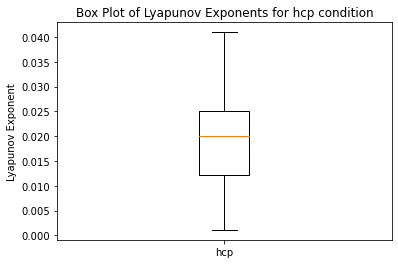

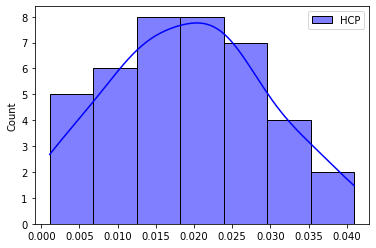

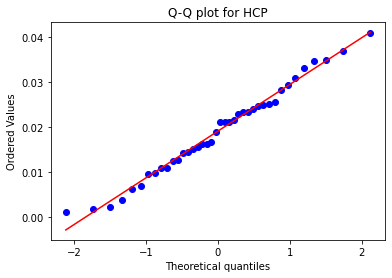

HCP data is normally distributed.


In [116]:
#HCP 

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

subjects = results['hcp'].keys()
lyapunov_exponents_hcp = [results['hcp'][subject] for subject in subjects]

# Box Plot
fig, ax = plt.subplots()
ax.boxplot(lyapunov_exponents_hcp)
ax.set_xticklabels(['hcp'])
ax.set_ylabel('Lyapunov Exponent')
ax.set_title('Box Plot of Lyapunov Exponents for hcp condition')
plt.show()

# Histogram
sns.histplot(data=lyapunov_exponents_hcp, kde=True, color='blue', label='HCP')
plt.legend()
plt.show()

# Q-Q plot
stats.probplot(lyapunov_exponents_hcp, dist="norm", plot=plt)
plt.title("Q-Q plot for HCP")
plt.show()

# Shapiro-Wilk test
shapiro_test_hcp = stats.shapiro(lyapunov_exponents_hcp)

# Check if the data is normally distributed based on the Shapiro-Wilk test results
alpha = 0.05  # significance level
if shapiro_test_hcp.pvalue > alpha:
    print("HCP data is normally distributed.")
else:
    print("HCP data is not normally distributed.")
